# Lecture 7: API, Online Data Extraction/Scraping by Python
## Author: Yue Li, PhD student in UBDC

1. What is an API?
   
    The words API stands for Application Programming Interface. 

    It's a set of rules, protocols, and tools that allows different software applications to communicate with each other. APIs define the methods and data formats that developers can use to interact with a service or a system, abstracting away the underlying complexity and providing a standardised way for applications to exchange information and request actions.

    In Python, some modules are making use of such API, to communicate with the system they run on.

    Example:
```python
import os
os.getcwd() # Return current working directory of the Jupyter Notebook
'Directory'
```

   In the above example, we are intrested to get the current working directory.

   To do so, we import the [os](https://docs.python.org/3/library/os.html#module-os) module,
   which in turn, calls some low-level functions to grab that directory, and then make sure it returns it as a string
   for our usage.
   
    You were never told which functions are these, nor how they do it.
    You are only intrested to get a string that contains that information.

    That's how APIs work, they are a set of functions, that they do something,
    and usually they return the result of their operation.
    
2. What is a REST WebService?
    
    REST (Representational state transfer) is a protocol, which defines methods that resources can be communicated between servers. A REST WebService, allows users through that server of not only get textual representation of that resource, but also to modify or create as needed.
    
    It uses HTTP methods like GET, POST, OPTIONS and etc generating responses that contain data using a JSON(JavaScript Object Notation) coded. For Python, JSON representation strings can be parsed as a dictionary.


In [1]:
# install the packages if you don't have them.
# !pip install requests
# !pip install pandas
# !pip install geopandas
# !pip install matplotlib
# !pip install contextily
# !pip install watermark

In [2]:
import requests
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime, timedelta

/Users/qzhao/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
%load_ext watermark

In [4]:
%watermark --python 

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0



In [5]:
%watermark --packages requests,json,pandas,geopandas,matplotlib,contextily

requests  : 2.25.1
json      : 2.0.9
pandas    : 1.2.4
geopandas : 0.10.2
matplotlib: 3.7.3
contextily: 1.2.0



## The Request Package

To communicate with a remote server, you will be using a popular python package called called '[Requests](https://requests.readthedocs.io/en/master/)'   which has managed to become a standard tool. 

> Requests:
> A 'higher' level python package that helps to send HTTP/1.1 requests.
It's build around pythons build-in 'lower' level web libraries.

```bash
# To install it:
$ pip install requests
```

And it's usage it's pretty  more straightforward:

```python
import requests
# Create a Response object from that URL
response = requests.get(url)

# the Response Object contains the .response of the server.
# Parse the data to a dictionary with the .json() function available
data = response.json()
print(data)

```

In [6]:
def get_data(url):
    response = requests.get(url)
    data = response.json()
    return data

## CCTV data

UBDC is using images from CCTV cameras located around Glasgow to fuel a ML model trained to extract various object from them. Results can be accessed through a web app that contains two API endpoints. One for the counts and another one listing the available locations.

More information about UBDC CCTV dataset can be found here: https://glasgow-cctv.ubdc.ac.uk/

Results: `https://glasgow-cctv.ubdc.ac.uk/api/yolo/records/`

Cameras: `https://glasgow-cctv.ubdc.ac.uk/api/general/cameras/`

Documentation/Overview: `https://glasgow-cctv.ubdc.ac.uk/api/docs`

### 1. Location of cameras

#### 1.1 Query the information

In [7]:
url = 'https://glasgow-cctv.ubdc.ac.uk/api/general/cameras/'
cameras = get_data(url)

In [8]:
cameras[0]

{'id': 12,
 'groups': [{'id': 2, 'name': 'City Centre'}],
 'camera_id': 'a13',
 'label': 'Byres Rd @ Dowanside Street (North)',
 'longitude': -4.294624,
 'latitude': 55.874577,
 'is_complete': True}

#### 1.2 Convert dictionary into dataframe

In [9]:
def dict_to_dataframe(data):
    data_dict = {}
    for feature in data[0]:
        data_dict[feature] = [each_record[feature] for each_record in data]
    data_df = pd.DataFrame.from_dict(data_dict)
    
    return data_df

In [10]:
cameras_df = dict_to_dataframe(cameras)[['id','label','longitude','latitude']]
cameras_df = cameras_df.sort_values(by=['id']).reset_index(drop=True)
cameras_df

id                                        label  longitude   latitude
0    12          Byres Rd @ Dowanside Street (North)  -4.294624  55.874577
1    18                   Broomielaw @ Washington St  -4.268509  55.856659
2    19                  Clyde walkway @ McAlpine St  -4.267323  55.856487
3    20                   Broomielaw @ James Watt St  -4.264330  55.856842
4    21                Clyde Walkway @ James watt st  -4.264515  55.856628
..  ...                                          ...        ...        ...
80  470                Hogganfield St @ Queenslie St  -4.191383  55.876311
81  471  Port Dundas Rd @ Cowcaddens Rd facing North  -4.253917  55.866227
82  472   Port Dundas Rd @ Cowcaddens Rd facing East  -4.253917  55.866227
83  473  Port Dundas Rd @ Cowcaddens Rd facing South  -4.253917  55.866227
84  474   Port Dundas Rd @ Cowcaddens Rd facing West  -4.253917  55.866227

[85 rows x 4 columns]

#### 1.3 Map all the cameras

1.3.1 Convert the dataframe into geodataframe (set CRS)

In [11]:
# Create a GeoDataFrame
cameras_df["geometry"] = gpd.points_from_xy(cameras_df["longitude"], cameras_df["latitude"])
# Set coordinate reference system
cameras_gdf = gpd.GeoDataFrame(cameras_df, crs="epsg:4326")
# Reproject
cameras_gdf = cameras_gdf.to_crs("epsg:3857")
cameras_gdf

id                                        label  longitude   latitude  \
0    12          Byres Rd @ Dowanside Street (North)  -4.294624  55.874577   
1    18                   Broomielaw @ Washington St  -4.268509  55.856659   
2    19                  Clyde walkway @ McAlpine St  -4.267323  55.856487   
3    20                   Broomielaw @ James Watt St  -4.264330  55.856842   
4    21                Clyde Walkway @ James watt st  -4.264515  55.856628   
..  ...                                          ...        ...        ...   
80  470                Hogganfield St @ Queenslie St  -4.191383  55.876311   
81  471  Port Dundas Rd @ Cowcaddens Rd facing North  -4.253917  55.866227   
82  472   Port Dundas Rd @ Cowcaddens Rd facing East  -4.253917  55.866227   
83  473  Port Dundas Rd @ Cowcaddens Rd facing South  -4.253917  55.866227   
84  474   Port Dundas Rd @ Cowcaddens Rd facing West  -4.253917  55.866227   

                           geometry  
0   POINT (-478075.357 7533487.893)  
1   POINT (-475168.248 7529933.276)  
2   POINT (-475036.223 7529899.162)  
3   POINT (-474703.044 7529969.572)  
4   POINT (-474723.638 7529927.128)  
..                              ...  
80  POINT (-466582.621 7533831.975)  
81  POINT (-473543.874 7531831.195)  
82  POINT (-473543.874 7531831.195)  
83  POINT (-473543.874 7531831.195)  
84  POINT (-473543.874 7531831.195)  

[85 rows x 5 columns]

1.3.2 Map the cameras

Filter the cameras location

In [12]:
borough_uk = gpd.read_file('data/district_borough_unitary.shp')
borough_gla = borough_uk.loc[borough_uk['Name']=='Glasgow City'].to_crs("epsg:3857")

camera_join = gpd.sjoin(cameras_gdf, borough_gla, how ='inner', op ='within')

/Users/qzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


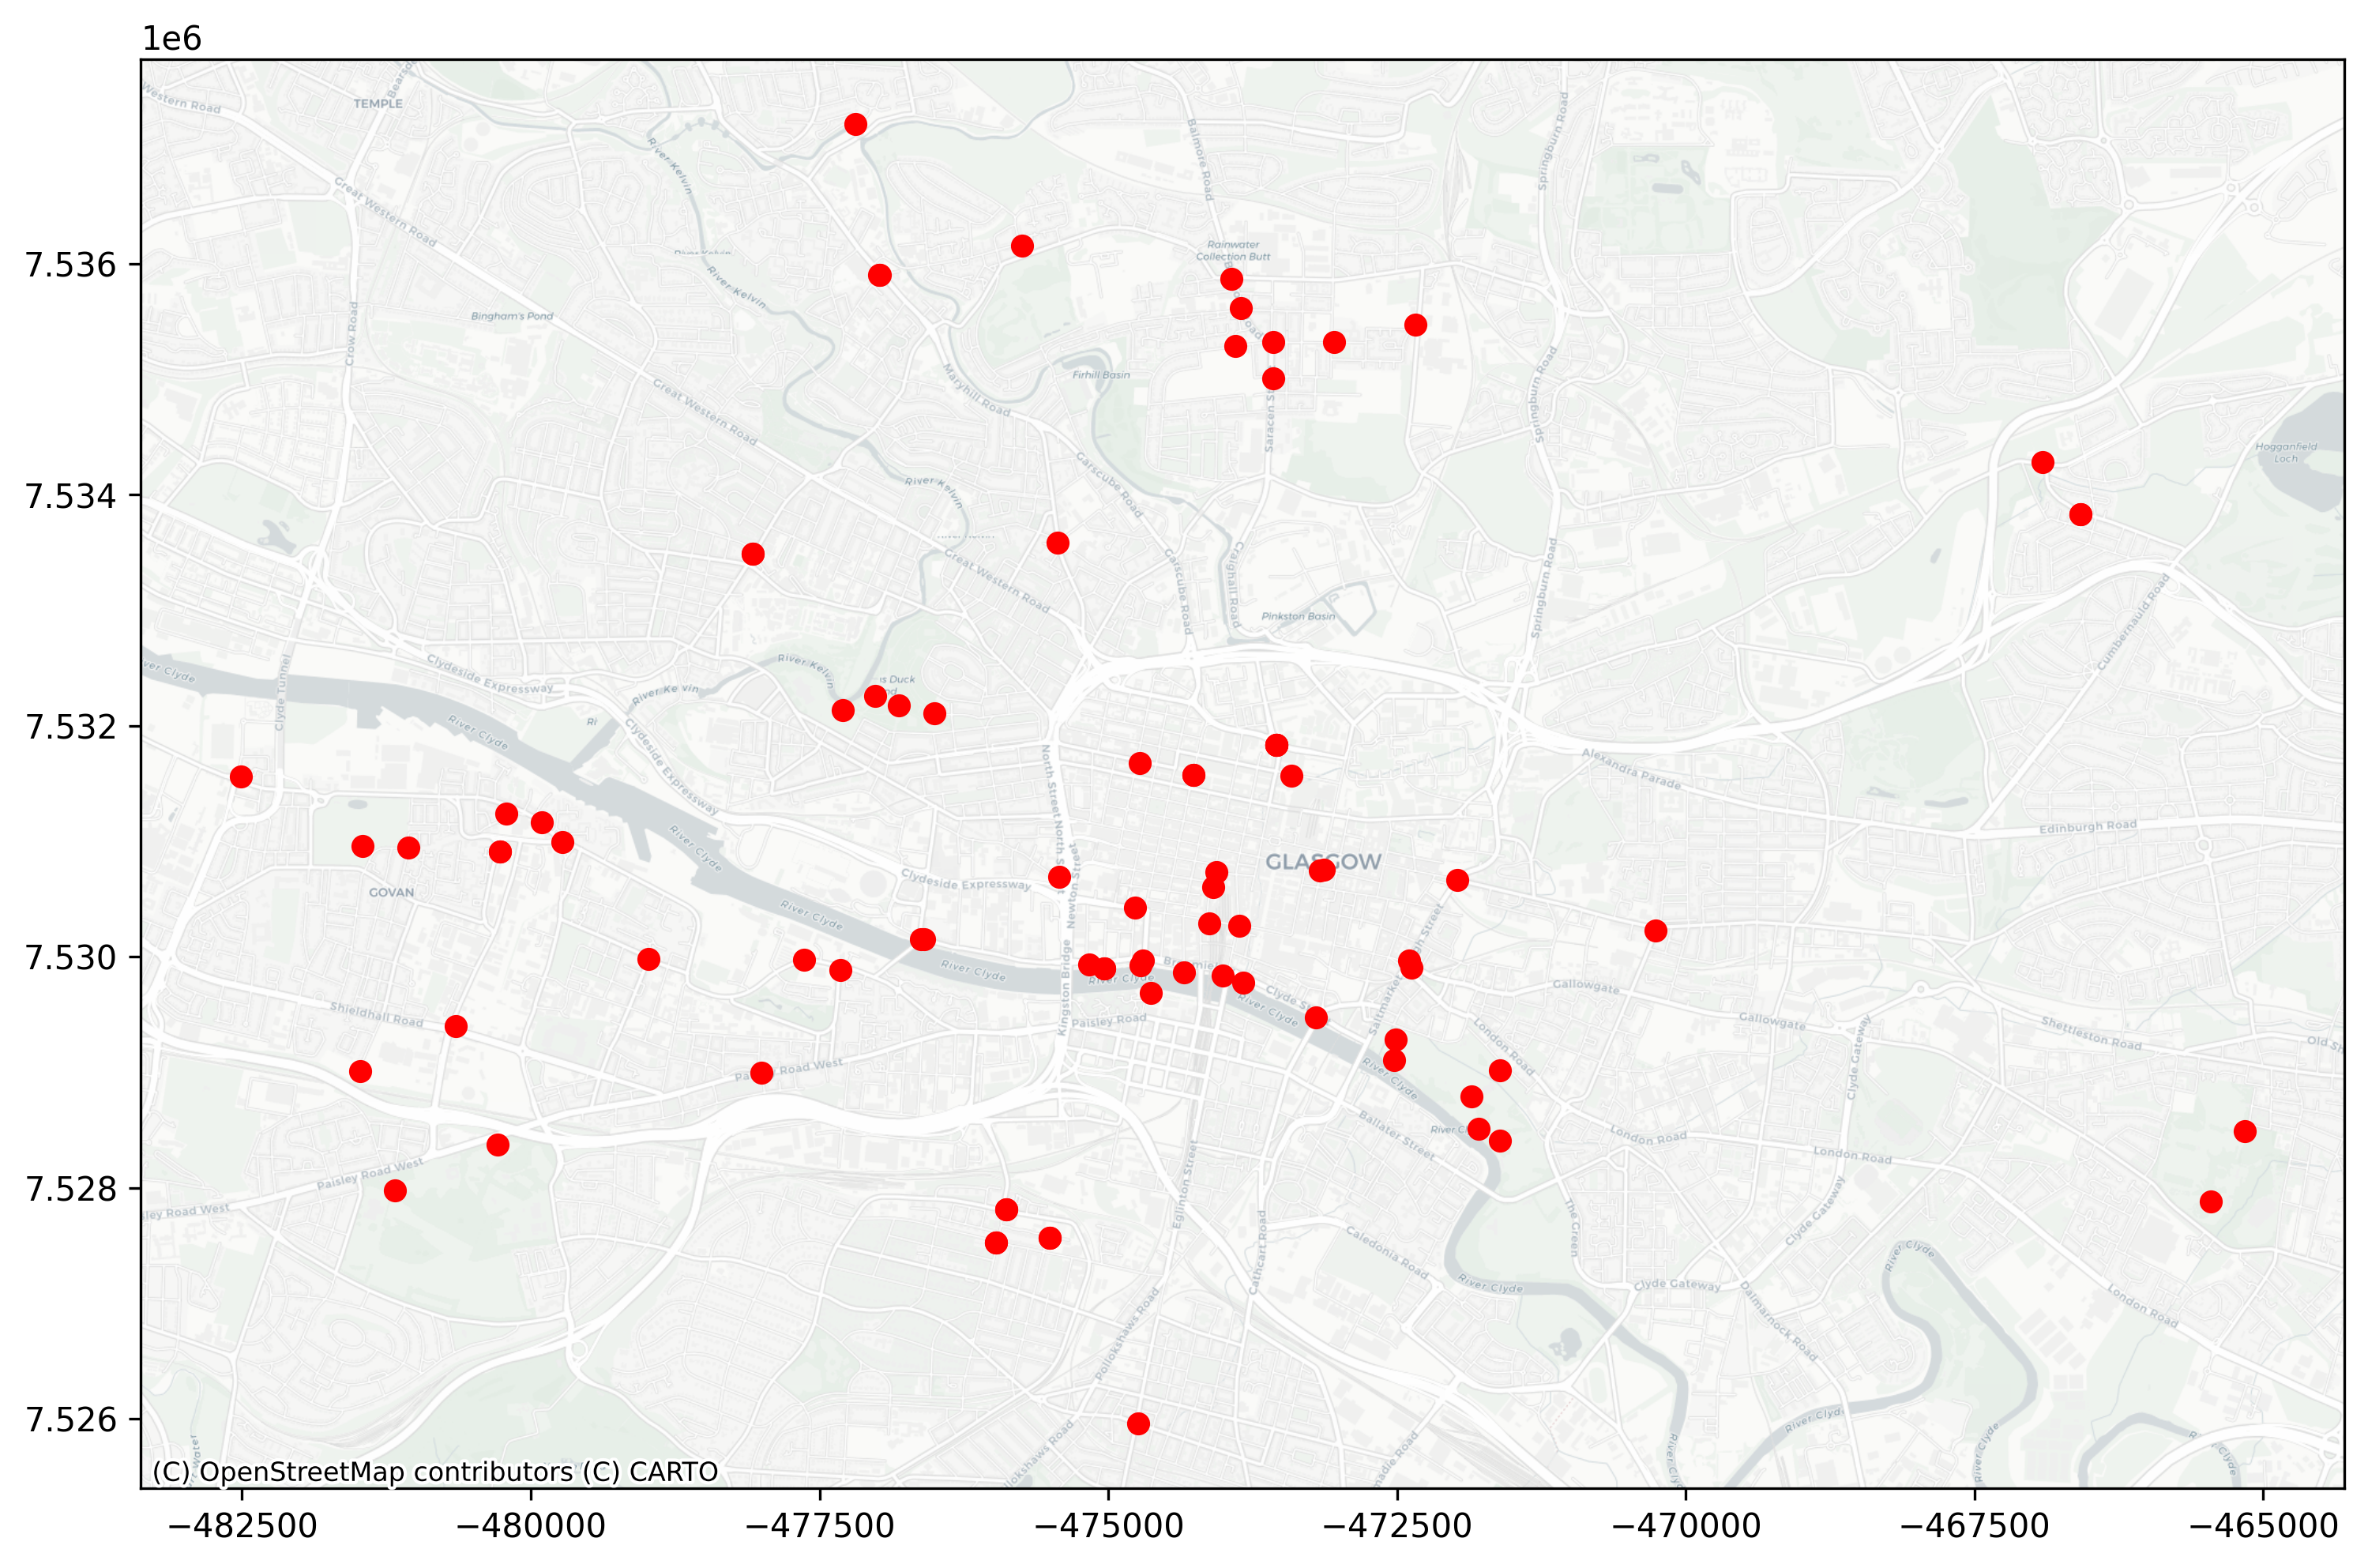

In [13]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300) 
#Plot the data
camera_join.plot(color = 'red',ax=ax)
#Add basemap
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron)

Interactive map

In [14]:
camera_join.explore(color="Red",tiles='cartodbpositron', tooltip=['id','label','latitude','longitude'], 
                    width=750, height=500)

### 2. CCTV Object Detection Results

We can get the URL through the API Documents: https://glasgow-cctv.ubdc.ac.uk/api/docs

#### 2.1 Select camera, query the information and create the dataframe

In [15]:
def get_results_for_camera(camera_id):
    
    url = f'https://glasgow-cctv.ubdc.ac.uk/api/yolo/records/?camera_id={camera_id}&page=1&page_size=335'
    results = get_data(url)['results']
    results_df = dict_to_dataframe(results)
    
    results_df['timestamp'] =pd.to_datetime(results_df.timestamp)
    results_df['totalCount'] = results_df.apply(
        lambda row: row.cars + row.buses + row.pedestrians + row.lorries + row.cyclists + row.motorcycles + 
        row.vans + row.taxis, axis=1)
    
    return results_df

**Lambda Function:** `lambda argument(s): expression`

- Lambda functions are similar to user-defined functions but without a name.

- Lambda functions are efficient whenever you want to create a function that will only contain **simple expressions** – that is, expressions that are usually **a single line of a statement**. They're also useful when you want to use the function once.

`lambda`: A keyword in Python for defining the anonymous function.

`arguments`: The input parameters or arguments to the function. A lambda function can have multiple variables depending on what you want to achieve.

`expression`: The single expression that the lambda function returns.

In [16]:
results_df = get_results_for_camera('427')
results_df

id                                     camera_details  camera_pk  \
0    3458526  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
1    3458566  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
2    3458524  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
3    3458565  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
4    3458520  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
..       ...                                                ...        ...   
330  3433773  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
331  3433772  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
332  3433771  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
333  3433766  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   
334  3433764  https://glasgow-cctv.ubdc.ac.uk/api/general/ca...        427   

    camera_ref                 timestamp camera_ok model_name  cars  \
0        a13p2 2025-02-19 23:30:35+00:00      True       yolo     0   
1        a13p2 2025-02-19 23:00:36+00:00      True       yolo     2   
2        a13p2 2025-02-19 22:30:36+00:00      True       yolo     0   
3        a13p2 2025-02-19 22:00:36+00:00      True       yolo     1   
4        a13p2 2025-02-19 21:30:35+00:00      True       yolo     0   
..         ...                       ...       ...        ...   ...   
330      a13p2 2025-02-13 02:30:36+00:00      True       yolo     1   
331      a13p2 2025-02-13 02:00:36+00:00      True       yolo     1   
332      a13p2 2025-02-13 01:30:37+00:00      True       yolo     1   
333      a13p2 2025-02-13 01:00:08+00:00     False       yolo     0   
334      a13p2 2025-02-13 00:30:08+00:00     False       yolo     0   

     pedestrians  cyclists  motorcycles  buses  lorries  vans  taxis  \
0              0         0            0      0        0     0      0   
1              0         0            0      0        0     0      0   
2              0         0            0      0        0     0      0   
3              0         0            0      0        0     0      0   
4              0         0            0      0        0     0      0   
..           ...       ...          ...    ...      ...   ...    ...   
330            0         0            0      0        0     0      0   
331            0         0            0      0        0     0      0   
332            1         0            0      0        0     0      0   
333            0         0            0      0        0     0      0   
334            0         0            0      0        0     0      0   

     totalCount  
0             0  
1             2  
2             0  
3             1  
4             0  
..          ...  
330           1  
331           1  
332           2  
333           0  
334           0  

[335 rows x 16 columns]

#### 2.2 Make time series plot

<Axes: xlabel='timestamp'>

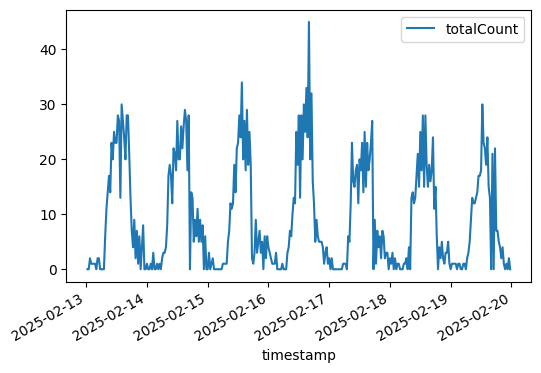

In [17]:
plt.rcParams["figure.dpi"] = 100
results_df.plot(x='timestamp', y='totalCount')

### The data seem to have a periodicity aspect. During day the day, more 'objects' were counted. The opposite, is happening during the night.

This effect is called **periodicity**, and can be seen in many datasets that observe a variable over time through multiple periods.

In the recent years, timeseries analysis libraries have been developed for Python. One of the many functions provided by these libraries is their ability to **decompose (=decomposing break down into its elements. In the case of a timeserie, the core elements are: trend, periodicity, and noise.)** These elements, can be used then for further data insights.

Using these libraries, and a well defined, dataset, it's very easy to perform these functions, which can give us some insights regarding the nature of the element that we are observing.

The `statsmodels` library, is a Python library, that has a primary focus to provide, statistical models for data analysis.
Among its other submodules that provides, it has a clean timeSeries analysis API, suitable for our needs.

> https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

```bash
# install statsmodel
$ pip install statsmodel
```

<ipython-input-18-22970a478b7f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = pd.DatetimeIndex(df2.timestamp)


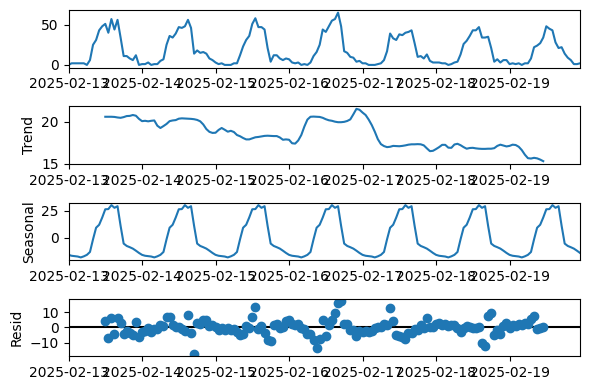

In [18]:
import statsmodels.api as sm

df2 = results_df[['timestamp', 'totalCount']]
df2['timestamp'] = pd.DatetimeIndex(df2.timestamp)
df2.set_index('timestamp', drop=True, inplace=True)

#  resample by, hour
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html
df3 = df2.resample('H').sum()

# decompose the timeseries to its elements using a naive model:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomposition = sm.tsa.seasonal_decompose(df3, model='additive')

# and plot.
fig = decomposition.plot()

#### Timeseries of the observed values are f(t) = Trend(t) + Periodicity(t) + Error(t) 

The rule of thumb to see if a model is performing adequate, is to examine the errors' chart: They should be as close to zero as possible.